# Systematic error on the Edelweiss C

The aim of this notebook is to estimate a rough systematic error on Edelweiss' reported C

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
#import mpld3
#mpld3.enable_notebook()

from scipy import optimize
import lmfit as lmf

import sys
sys.path.append('../python/')
from EdwRes import *

In [2]:
# import data from Edelweiss
res_data = pd.read_csv("edelweiss_NRwidth_GGA3_data.txt", skiprows=1, \
                       names=['E_recoil', 'sig_NR', 'E_recoil_err', 'sig_NR_err'], \
                       delim_whitespace=True)

resER_data = pd.read_csv("edelweiss_ERwidth_GGA3_data.txt", skiprows=1, \
                         names=['E_recoil', 'sig_ER', 'sig_ER_err'], \
                         delim_whitespace=True)

resER_data = resER_data.sort_values(by='E_recoil')

print (res_data.head(10))
E_recoil = res_data["E_recoil"]
sig_NR = res_data["sig_NR"]
sig_NR_err = res_data['sig_NR_err']

   E_recoil    sig_NR  E_recoil_err  sig_NR_err
0   16.1946  0.062345      0.946176    0.001157
1   16.4428  0.062345      0.945278    0.001157
2   44.2627  0.046528      0.992477    0.001543
3   24.5012  0.059397      0.992477    0.001185
4   97.7172  0.044847      1.033260    0.002783
5   58.4014  0.050082      0.991830    0.002288
6   34.2156  0.053417      1.033260    0.001102


In [ ]:
# parameters set from numbers reported in Edelweiss paper
ion_center_0keV = 1.3
ion_guard_0keV = 1.5
heat_0keV = 0.4
ion_122keV = 3.1 #3.3 #3.1
heat_122keV = 2.7
V = 4

In [10]:
# lmfit needs a residuals function
def residualNR(params, x, data, eps_data):
    ion_center_0keV = params['ion_center_0keV']
    ion_guard_0keV = params['ion_guard_0keV']
    ion_122keV = params['ion_122keV']
    heat_0keV = params['heat_0keV']
    heat_122keV = params['heat_122keV']
    V = params['V']
    aH = params['aH']
    C = params['C']

    fit_func = get_sig_nuc_func(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, V, aH, C)
    
    model = fit_func(x)

    return (data-model) / eps_data

def residualER(params, x, data, eps_data):
    ion_center_0keV = params['ion_center_0keV']
    ion_guard_0keV = params['ion_guard_0keV']
    ion_122keV = params['ion_122keV']
    heat_0keV = params['heat_0keV']
    heat_122keV = params['heat_122keV']
    V = params['V']
    aH = params['aH']

    fit_func = get_sig_gamma_func(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, V, aH)
    
    model = fit_func(x)

    return (data-model) / eps_data

In [14]:
# Edelweiss fits aH first
paramsER = lmf.Parameters()
paramsER.add('ion_center_0keV', value=ion_center_0keV, vary=False)
paramsER.add('ion_guard_0keV', value=ion_guard_0keV, vary=False)
paramsER.add('ion_122keV', value=ion_122keV, vary=False)
paramsER.add('heat_0keV', value=heat_0keV, vary=False)
paramsER.add('heat_122keV', value=heat_122keV, vary=False)
paramsER.add('V', value=V, vary=False)
paramsER.add('aH', value=0.01638)

mask = [True, True, False, False, True, True, True, True, True]
lmfoutER = lmf.minimize(residualER, paramsER, \
                        args=(resER_data["E_recoil"][mask], resER_data["sig_ER"][mask], resER_data["sig_ER_err"][mask]))

print('lmfit result--ER')
print(lmf.report_fit(lmfoutER.params))

lmfit result--ER
[[Variables]]
    ion_center_0keV:  1.3 (fixed)
    ion_guard_0keV:   1.5 (fixed)
    ion_122keV:       3.1 (fixed)
    heat_0keV:        0.4 (fixed)
    heat_122keV:      2.7 (fixed)
    V:                4 (fixed)
    aH:               0.01638269 +/- 6.6618e-04 (4.07%) (init = 0.01638)
None


In [23]:
# Woo, set paramters!
paramsNR = lmf.Parameters()
paramsNR.add('ion_center_0keV', value=ion_center_0keV, vary=False)
paramsNR.add('ion_guard_0keV', value=ion_guard_0keV, vary=False)
paramsNR.add('ion_122keV', value=ion_122keV, vary=False)
paramsNR.add('heat_0keV', value=heat_0keV, vary=False)
paramsNR.add('heat_122keV', value=heat_122keV, vary=False)
paramsNR.add('V', value=V, vary=False)
paramsNR.add('aH', value=lmfoutER.params['aH'], vary=False)
paramsNR.add('C', value=0.04)

# E_recoil[2::], sig_NR[2::], sigma=sig_NR_err[2::]
lmfoutNR = lmf.minimize(residualNR, paramsNR, args=(E_recoil[2::], sig_NR[2::], sig_NR_err[2::]))
#print(lmf.fit_report(lmfout))
print('lmfit result--NR')
print(lmf.report_fit(lmfoutNR.params))

lmfit result--NR
[[Variables]]
    ion_center_0keV:  1.3 (fixed)
    ion_guard_0keV:   1.5 (fixed)
    ion_122keV:       3.1 (fixed)
    heat_0keV:        0.4 (fixed)
    heat_122keV:      2.7 (fixed)
    V:                4 (fixed)
    aH:               0.01638269 (fixed)
    C:                0.03878383 +/- 0.00154461 (3.98%) (init = 0.04)
None


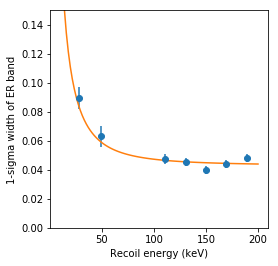

In [22]:


sig_er_func = get_sig_gamma_func(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, V, aH=lmfoutER.params['aH'])

plt.errorbar(resER_data["E_recoil"][mask], resER_data["sig_ER"][mask], yerr=resER_data["sig_ER_err"][mask], fmt="o")

E_recoil_arr = np.linspace(10, 200, 100)
plt.plot(E_recoil_arr, sig_er_func(E_recoil_arr))

plt.xlabel("Recoil energy (keV)")
plt.ylabel("1-sigma width of ER band")
plt.ylim(0,0.15)
ax = plt.gca()
ratio = 1
ax.set_aspect(1.0/ax.get_data_ratio()*ratio)

Text(0,0.5,'1-sigma width of NR band')

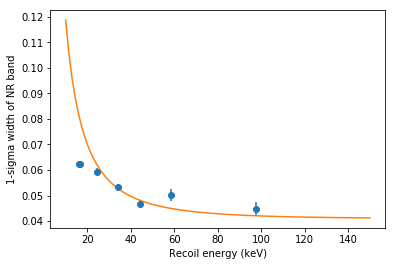

In [24]:
# get_sig_nuc_func_fit(FWHM_center, FWHM_guard, FWHM122_ion, FWHM0_heat, FWHM122_heat, V, aH=None, C = None)
#sig_nr_GGA3 = get_sig_nuc_func(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, V, aH)
sig_nr_func = get_sig_nuc_func(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, V, \
                               aH=lmfoutER.params['aH'], C=lmfoutNR.params['C'])

plt.errorbar(E_recoil, sig_NR, yerr=sig_NR_err, fmt="o")

E_recoil_arr = np.linspace(10, 150, 100)
plt.plot(E_recoil_arr, sig_nr_func(E_recoil_arr))

plt.xlabel("Recoil energy (keV)")
plt.ylabel("1-sigma width of NR band")
#plt.ylim(0, 0.1)

In [6]:
# How many counts are in the gaussian for 
# a particular energy bin?
# Here, GGA1 in bin 40 < ER < 60 keV
N = 125*3+80*2+55*2+25*3
print (N)

720


In [7]:
def std_error_mean(sig, N):
    return sig/np.sqrt(N)

def std_error_stdDev(sig, N):
    return sig/np.sqrt(2*(N-1))

In [17]:
# For the 40 < ER < 50 keV bin for GGA3 NR data,
# the mean is 0.047 and the error is reported as 0.0015
print (std_error_mean(0.047, 500))
print (std_error_stdDev(0.047, 500))

0.0021019038988498023
0.0014877590039073583
